In [1]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [2]:
%matplotlib inline

In [3]:
import glob
import os

fnames = sorted(glob.glob(
    os.path.join(
        os.environ["MEDS_DIR"], 
        "des-pizza-slices-y6-test", 
        "**", 
        "*piff-model.fits"
    ),
    recursive=True,
))

print(len(fnames))

2680


In [4]:
import pickle

with open("fnames.pkl", "wb") as fp:
    pickle.dump(fnames, fp)

In [6]:
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)
import tqdm
import joblib

def _process(fname):
    piff_mod = piff.read(fname)

    if "_z_" in fname:
        piff_kwargs = {"IZ_COLOR": 0.34}
    else:
        piff_kwargs = {"GI_COLOR": 0.61}

    try:
        t_arr = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354, grid_size=128)
    except Exception:
        return None
    
    if False:
        data = measure_star_t_for_piff_model(piff_mod, piff_prop=list(piff_kwargs.keys())[0])
        ts_arr = map_star_t_to_grid(data, grid_size=256)
        darr = t_arr - ts_arr
    return t_arr.ravel()
        

jobs = []
for fname in fnames:
    jobs.append(joblib.delayed(_process)(fname))
    
with joblib.Parallel(n_jobs=-1, verbose=10) as par:
    arrs = par(jobs)

arr = np.hstack(arrs)

fitsio.write("data.fits", arr, clobber=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.7min
/gpfs02/astro/workarea/beckermr/miniconda3/envs/desy6/lib/python3.9/site-packages/ngmix/admom/admom.py:401: RuntimeWa

In [7]:
arr = fitsio.read("data.fits")
with open("fnames.pkl", "rb") as fp:
    fnames = pickle.load(fp)

True


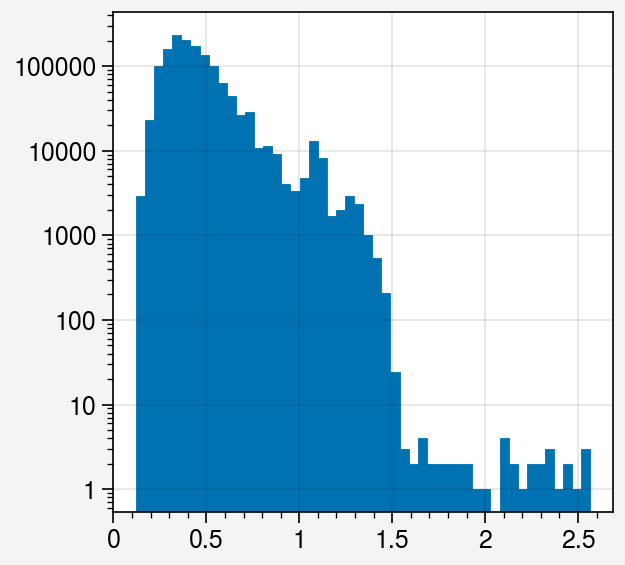

In [8]:
print(np.any(np.isnan(arr)))

fig, axs = pplt.subplots()
axs.hist(arr, bins=50, log=True);

kind of odd: 8 0.10332868374306303
kind of odd: 21 0.12806413555162366
kind of odd: 23 0.10046839058080015
kind of odd: 58 0.10093715498557043
kind of odd: 86 0.11058637549312156
kind of odd: 114 0.12541050246121951
really bad: 180 0.12851736660467114 True
really bad: 290 0.04057452211463669 True
really bad: 449 1.8242585562702551 True
kind of odd: 471 0.11012460656400047
really bad: 788 0.5498566474206754 True
really bad: 808 0.19011407456662177 True
really bad: 976 0.19133846163663337 True
really bad: 996 1.6376420212384752 True
kind of odd: 1046 0.12421765261178064
kind of odd: 1133 0.11510746669898597
kind of odd: 1166 0.121960868533736
really bad: 1169 1.3806307794523232 True
really bad: 1375 0.3289519307386436 True
kind of odd: 1401 0.10596896955946145
kind of odd: 1461 0.10339315197063459
kind of odd: 1469 0.10788961484836279
really bad: 1562 0.16392298180441278 True
kind of odd: 1880 0.10325541069921085
kind of odd: 2051 0.10904739663327823
kind of odd: 2112 0.12422430283530161

Text(0.5, 0, 'log10[max(abs(Tgal - median(Tgal)))]')

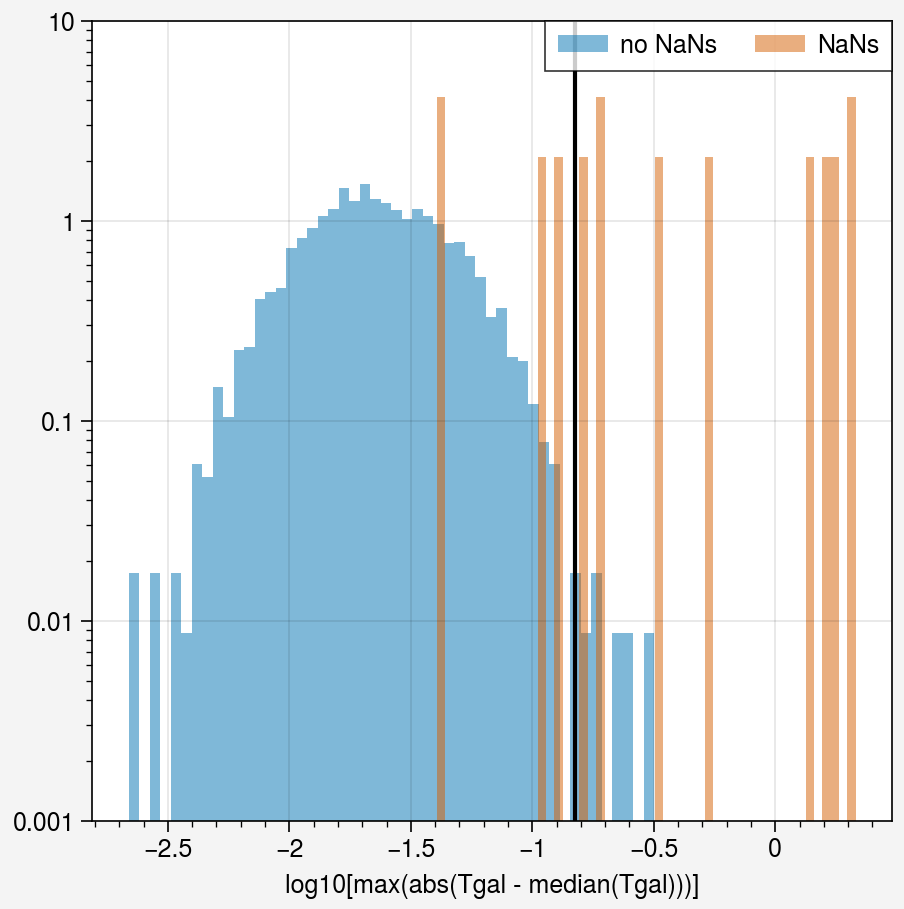

In [43]:
arr_bad = []
arr_good = []
arr_all = []
isnan = []

naninds = []
cutinds = []
oddinds = []

def _stat(a):
    return np.nanmax(np.abs(a-np.nanmedian(a)))


ng = 512
for i in range(len(arr)//ng):
    start = i * ng
    stop = start + ng
    a = arr[start:stop]
    sa = _stat(a)
    arr_all.append(sa)
    if np.any(np.isnan(a)):
        isnan.append(True)
        arr_bad.append(sa)
        naninds.append(i)
        print("really bad:", i, arr_bad[-1], np.any(np.isnan(a)))
    else:
        isnan.append(False)
        arr_good.append(sa)
        
        if sa > 0.1 and sa <= 0.15:
            oddinds.append(i)
            print("kind of odd:", i, sa)
        elif sa > 0.15:
            cutinds.append(i)
        
cut = 0.15
isnan = np.array(isnan)
arr_all = np.array(arr_all)
print(np.mean(isnan | (arr_all > cut)))

assert stop == len(arr)
arr_bad = np.log10(np.hstack(arr_bad))
arr_good = np.log10(np.hstack(arr_good))

fig, axs = pplt.subplots(refwidth=4)
axs.hist(arr_good, bins=50, log=True, density=True, alpha=0.5, label="no NaNs")
axs.hist(arr_bad, bins=50, log=True, density=True, alpha=0.5, label="NaNs")
axs.vlines(np.log10(cut), 0.001, 10, color='k')
axs.legend()
axs[0].set_xlabel("log10[max(abs(Tgal - median(Tgal)))]")

80


Text(0.5, 0, 'gal T - star T')

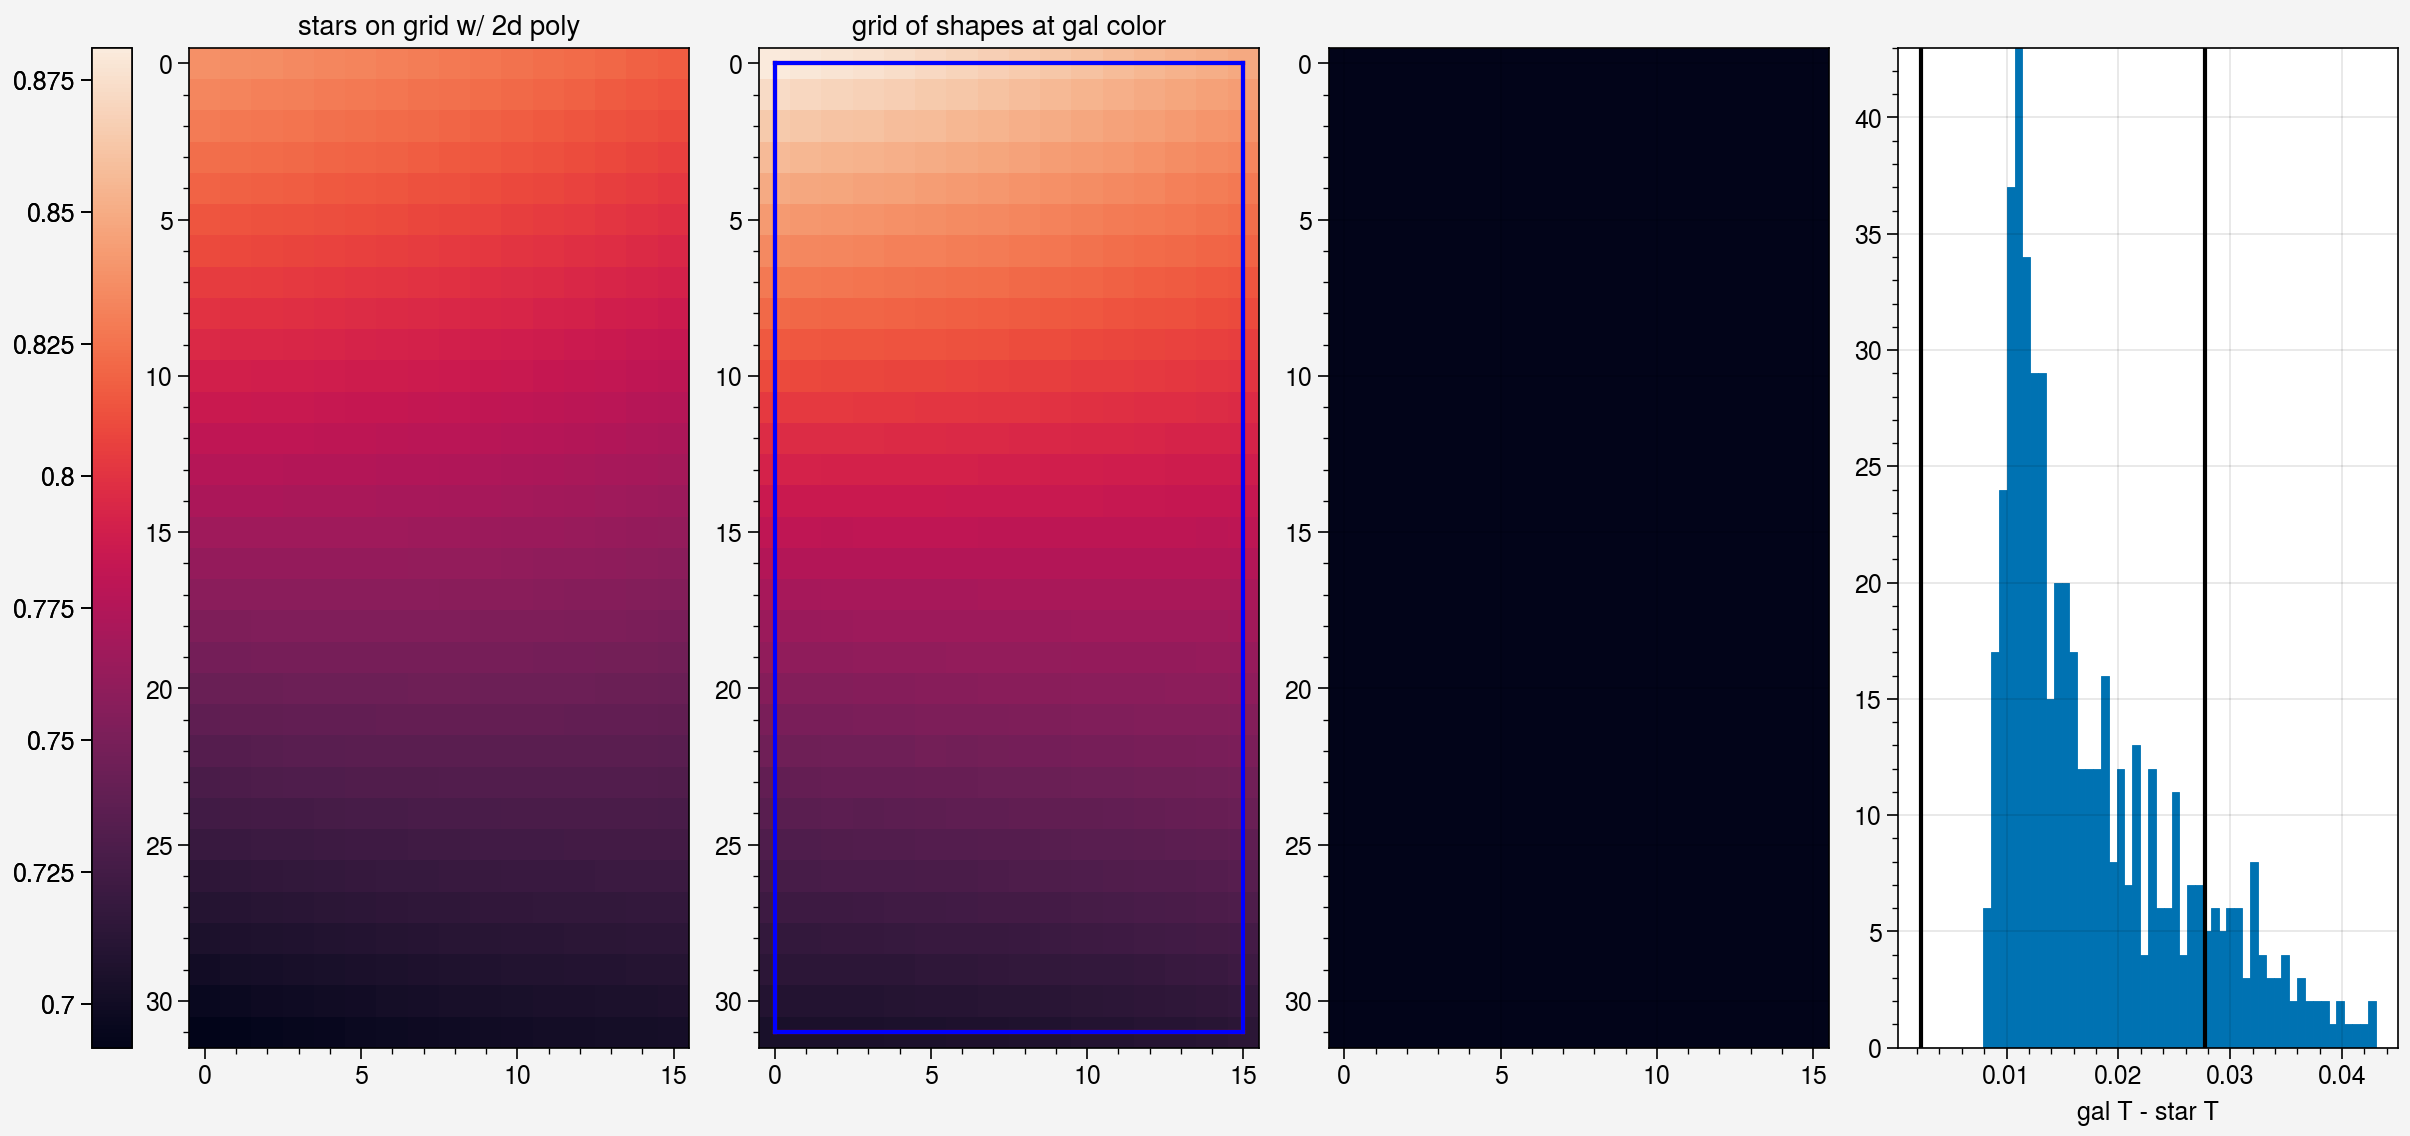

In [44]:
sind = 8

piff_mod = piff.read(fnames[sind])
print(len(piff_mod.stars))

if "_z_" in fnames[sind]:
    piff_kwargs = {"IZ_COLOR": 0.34}
else:
    piff_kwargs = {"GI_COLOR": 0.61}


thresh = 5
t_arr = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)
data = measure_star_t_for_piff_model(piff_mod, piff_prop=list(piff_kwargs.keys())[0])
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs=piff_kwargs, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, piff_kwargs=piff_kwargs, seed=11, verbose=False,
    flag_bad_thresh=2, any_bad_thresh=5,
)

vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=4, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

axs[2].imshow(res_sg["bad_msk"], cmap="rocket")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * 2
h = axs[3].hist(harr, bins=50)
axs[3].vlines([np.nanmedian(harr)-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[3].set_xlabel("gal T - star T")

In [ ]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[1], BANDS[0])
) as fp:
    yml = yaml.safe_load(fp.read())

In [ ]:
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)

In [ ]:
# find a bad model
import tqdm

for sind, src in tqdm.tqdm(enumerate(yml["src_info"]), total=len(yml["src_info"])):
    fname = src["piff_path"]

    pmod = piff.read(fname)
    if "_z_" in fname:
        piff_kwargs = {"IZ_COLOR": 0.34}
    else:
        piff_kwargs = {"GI_COLOR": 0.61}
    t_gal = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)    
    bf = np.mean(np.isnan(t_gal))
    
    if bf > 0:
        print(sind)
        break

In [ ]:
from esutil.pbar import prange
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

tot = 0
flagged = 0

TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]


for i in prange(4):
    for j in range(4):
        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (TNAMES[i], BANDS[j])
        ) as fp:
            yml = yaml.safe_load(fp.read())
        
        for _sind, src in enumerate(yml["src_info"]):
            tot += 1
            if (compute_piff_flags(
                        piff_info=src["piff_info"],
                        max_fwhm_cen=3.6, 
                        min_nstar=35, 
                        max_exp_T_mean_fac=4, 
                        max_ccd_T_std_fac=0.3,
                    ) != 0):
                flagged += 1

print(flagged, flagged / tot)

In [ ]:
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

TNAMES = [
    "DES0131-3206", 
    "DES0137-3749", 
    "DES0221-0750", 
    "DES0229-0416",
]

tfind = "D00372620_i_c62_r5702p01_piff-model.fits"
BANDS = [tfind.split("_")[1]]
sind = None

for band in BANDS:
    for tname in TNAMES:
        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (tname, band)
        ) as fp:
            yml = yaml.safe_load(fp.read())

        for _sind, src in enumerate(yml["src_info"]):
            if tfind in src["piff_path"]:
                sind = _sind
                print(
                    "sind|flags|tname:",
                    sind,
                    compute_piff_flags(
                        piff_info=src["piff_info"],
                        max_fwhm_cen=3.6, 
                        min_nstar=25, 
                        max_exp_T_mean_fac=4, 
                        max_ccd_T_std_fac=0.3,
                    ),
                    yml["tilename"],
                )
                break
        if sind is not None:
            break
    if sind is not None:
        break


In [ ]:
np.nanmax(np.abs(harr - np.nanmedian(harr)))/nanmad(harr)

In [ ]:
np.mean(res_sg["bad_msk"])

In [ ]:
t_gal[0, 0] = np.nan
np.mean(np.isnan(t_gal))

In [ ]:
list(piff_kwargs.keys())[0]

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [ ]:
g = galsim.Gaussian(fwhm=0.5).dilate(1.1)

In [ ]:
g

In [ ]:
import fitsio

In [ ]:
fitsio.write?